In [3]:
import zipfile
zip_ref = zipfile.ZipFile('data/chimpgorilla.zip', 'r')
zip_ref.extractall('data/')
zip_ref.close()

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = "data/chimpgorilla/"
sz=224

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.backends.cudnn.enabled

True

In [7]:
os.listdir(PATH)

['.ipynb_checkpoints', 'valid', 'models', 'train', 'tmp']

In [8]:
os.listdir(f'{PATH}valid')

['chimpanzee', 'gorilla']

In [9]:
files = os.listdir(f'{PATH}valid/chimpanzee')[:5]
files

['68. 200352022-001_XS.jpg',
 '56. Chimpanzee-1600x600px.jpg',
 '75. DWu5PoSW0AARQxy.jpg',
 '54. large-Chimpanzee-photo.jpg',
 '60. Baby%20chimpanzee.jpg']

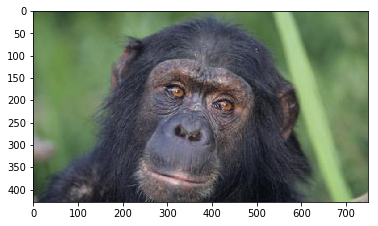

In [10]:
img = plt.imread(f'{PATH}valid/chimpanzee/{files[0]}')
plt.imshow(img);

In [11]:
img.shape

(428, 750, 3)

In [12]:
img[:4,:4]

array([[[ 74, 102,  62],
        [ 74, 102,  62],
        [ 75, 103,  63],
        [ 76, 104,  64]],

       [[ 74, 102,  62],
        [ 74, 102,  62],
        [ 75, 103,  63],
        [ 76, 104,  64]],

       [[ 74, 102,  62],
        [ 75, 103,  63],
        [ 75, 103,  63],
        [ 76, 104,  64]],

       [[ 75, 103,  62],
        [ 75, 103,  62],
        [ 76, 104,  63],
        [ 77, 105,  64]]], dtype=uint8)

In [13]:
shutil.rmtree(f'{PATH}tmp', ignore_errors=True)
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)

100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                
    0      0.740141   0.542674   0.706562  
    1      0.625581   0.406577   0.845313        
    2      0.498124   0.3838     0.82875         



[0.38379964, 0.8287500143051147]

In [14]:
# This is the label for a val data
data.val_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [16]:
# from here we know that 'chimpanzee' is label 0 and 'gorilla' is label 1.
data.classes

['chimpanzee', 'gorilla']

In [17]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(89, 2)

In [18]:
log_preds[:10]

array([[-0.14536, -2.00035],
       [-0.05061, -3.00873],
       [-0.2506 , -1.50659],
       [-0.00161, -6.43365],
       [-0.04778, -3.06504],
       [-0.07197, -2.6673 ],
       [-0.76221, -0.62855],
       [-0.08296, -2.53065],
       [-0.11182, -2.24625],
       [-0.08146, -2.54811]], dtype=float32)

In [20]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(gorilla)

In [21]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [22]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [23]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [24]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


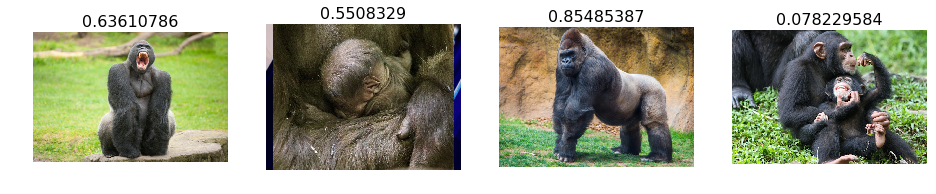

In [25]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


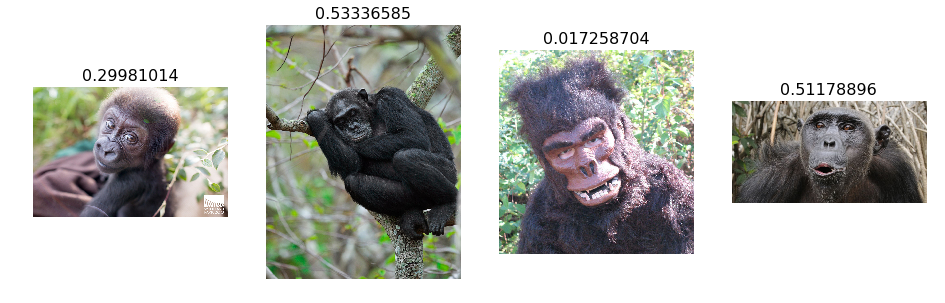

In [26]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [27]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct chimps


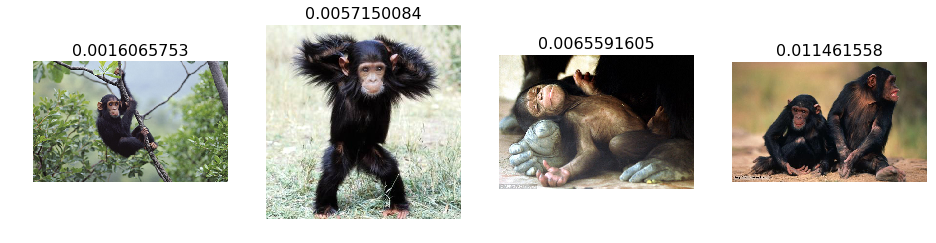

In [28]:
plot_val_with_title(most_by_correct(0, True), "Most correct chimps")

Most correct gorillas


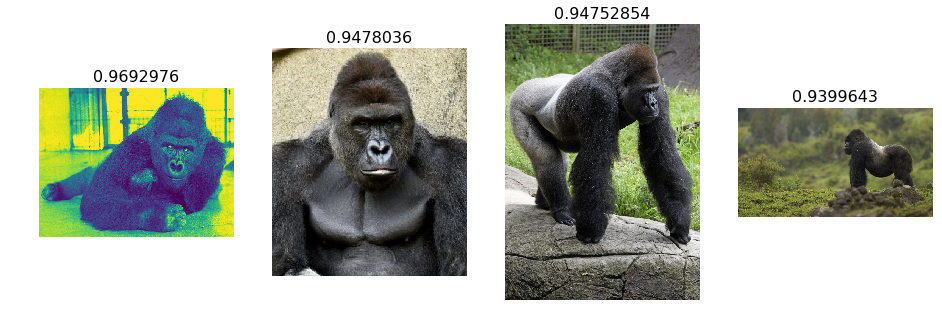

In [29]:
plot_val_with_title(most_by_correct(1, True), "Most correct gorillas")

Most incorrect chimps


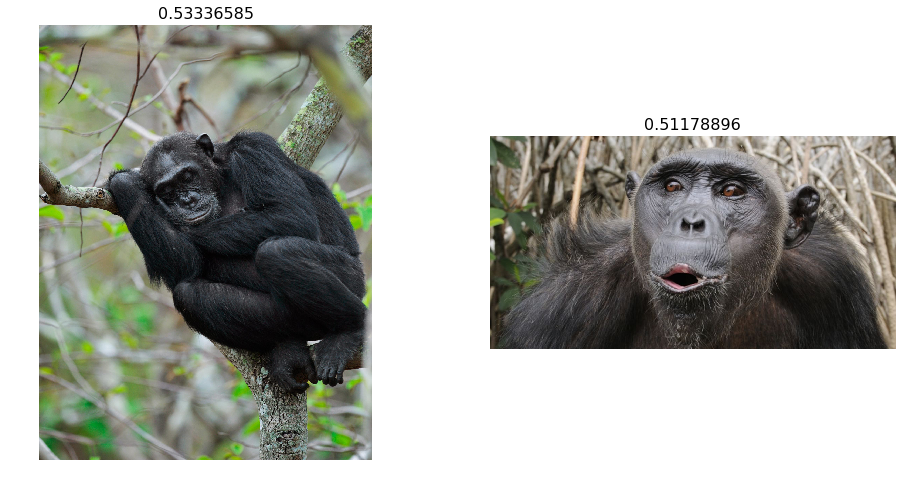

In [30]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect chimps")

Most incorrect gorillas


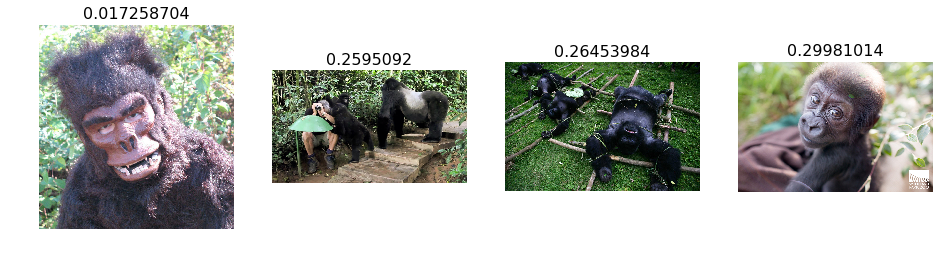

In [31]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect gorillas")

Most uncertain predictions


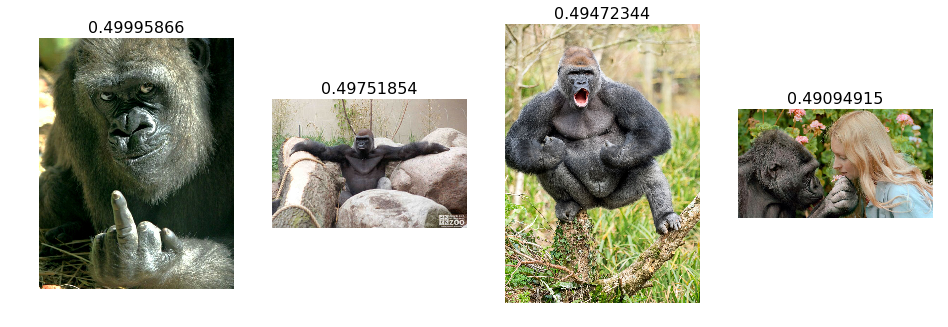

In [32]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [33]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [34]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy        
    0      0.979815   1.05176    0.399375  



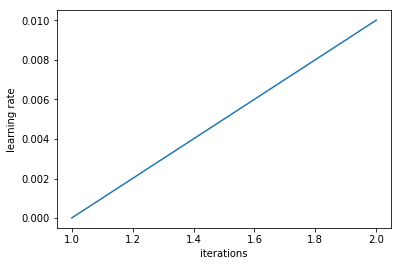

In [35]:
learn.sched.plot_lr()

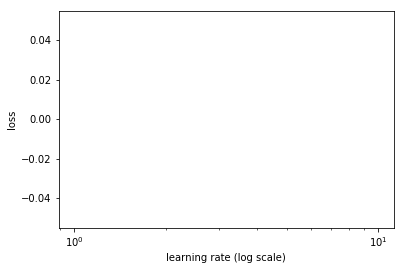

In [36]:
learn.sched.plot()

In [37]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [38]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [39]:
ims = np.stack([get_augs() for i in range(6)])

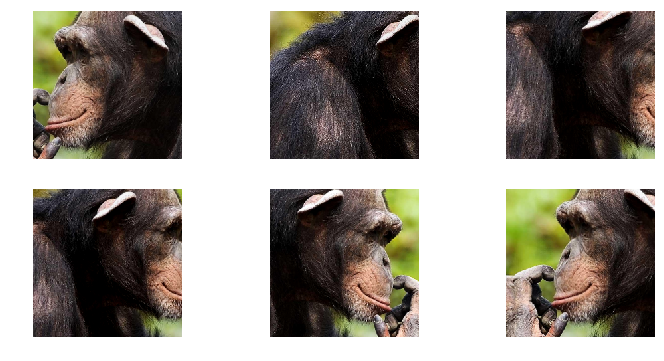

In [40]:
plots(ims, rows=2)

In [41]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [42]:
learn.fit(1e-2, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy        
    0      0.730807   1.174356   0.359375  



[1.1743562, 0.359375]

In [43]:
learn.precompute=False

In [44]:
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                
    0      0.627932   0.996593   0.399375  
    1      0.573358   0.816905   0.515                   
    2      0.52583    0.644731   0.629688                



[0.6447314, 0.6296875029802322]

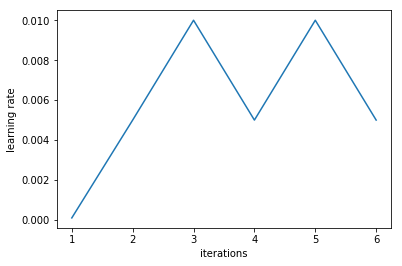

In [45]:
learn.sched.plot_lr()